<a href="https://colab.research.google.com/github/WankhedeAmey/Regression-on-Life-Expectancy-Dataset/blob/main/Regression_on_Life_Expectancy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Predict life expectancy based on features defined in the dataset like year, percentage expenditure, gdp, schooling, etc.

In [114]:
# Import Libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from google.colab import files

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import AlphaSelection

In [4]:
le_file = files.upload()

In [31]:
# Read Data
le = pd.read_csv('LifeExpectancy.csv', index_col=[0])
print(le.shape)
le.head()

(2938, 22)


,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [94]:
# Preprocessing

def min_preprocessing(X) :
  print(f'Shape before: {X.shape}')

  #drop missing values
  X = X.dropna()
  # Remove categorical columns
  X = X.drop(columns=categorical_cols)

  print(f'Shape after: {X.shape}')

  return X

## Missing values
le.isna().sum().sort_values(ascending=False)

## Grabbing Categorical Variables(each) & changing their types to 'category'
categorical_cols = list(le.dtypes[le.dtypes=='object'].index.values)

for col in categorical_cols :
  le[col] = le[col].astype('category')

le = min_preprocessing(le)


Shape before: (1649, 20)
Shape after: (1649, 20)


In [86]:
# Split the data into training and testing
X = le.loc[:, le.columns != 'life_expectancy']
y = le['life_expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1104, 19), (1104,), (545, 19), (545,))

In [43]:
# Applying linear regression

## Using scikit-linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train) #Fit the model on training data
y_pred = lr.predict(X_train) # Make prediction using this model

## Metrics

mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
norm_mse = 1 - r_squared

print(f'\tMean Squared Error: {mse}\n \tNormalized Mean Squared Error: {norm_mse}\n \tR2 score: {r_squared}')

	Mean Squared Error: 12.382446422227288
 	Normalized Mean Squared Error: 0.16481691600243642
 	R2 score: 0.8351830839975636


In [51]:
# Using cross validation

cross_val_metrics = pd.DataFrame(columns=['MSE', 'NMSE', 'R2'])
kf = KFold(n_splits=5)
i = 1

for train_index, test_index in kf.split(X_train) :
  print(f'Split {i}: \n\tTest Folds:[{i}]\n\tTrain Folds: {[j for j in range(1, 6) if j != i]}')

  X_train_fold = X_train.values[train_index]
  y_train_fold = y_train.values[train_index]
  X_test_fold  = X_train.values[test_index]
  y_test_fold  = y_train.values[test_index]

  lr = LinearRegression().fit(X_train_fold, y_train_fold)
  y_pred_fold = lr.predict(X_test_fold)

  fold_mse  = mean_squared_error(y_test_fold, y_pred_fold)
  fold_nmse = 1 - r2_score(y_test_fold, y_pred_fold)
  fold_r2   = r2_score(y_test_fold, y_pred_fold)
  print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

  cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse, fold_nmse, fold_r2]
  i = i + 1

cross_val_metrics.loc['Mean', :] = cross_val_metrics.mean()
print(f'\n {cross_val_metrics}')

Split 1: 
	Test Folds:[1]
	Train Folds: [2, 3, 4, 5]
	MSE: 13.098 NMSE: 0.181 R2: 0.819
Split 2: 
	Test Folds:[2]
	Train Folds: [1, 3, 4, 5]
	MSE: 12.473 NMSE: 0.152 R2: 0.848
Split 3: 
	Test Folds:[3]
	Train Folds: [1, 2, 4, 5]
	MSE: 13.306 NMSE: 0.178 R2: 0.822
Split 4: 
	Test Folds:[4]
	Train Folds: [1, 2, 3, 5]
	MSE: 13.949 NMSE: 0.175 R2: 0.825
Split 5: 
	Test Folds:[5]
	Train Folds: [1, 2, 3, 4]
	MSE: 12.749 NMSE: 0.201 R2: 0.799

               MSE      NMSE        R2
Fold 1  13.098016  0.181042  0.818958
Fold 2   12.47264  0.151801  0.848199
Fold 3  13.305786  0.177765  0.822235
Fold 4  13.948925  0.174503  0.825497
Fold 5  12.748923  0.201127  0.798873
Mean    13.114858  0.177248  0.822752


In [62]:
# Applying Ridge Regression

ridge_cross_val_matrics = pd.DataFrame(columns=['mean-MSE', 'mean-NMSE', 'mean-R2'])

lamdbas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10, 50, 100] # Choosing random hyperparameters

for lambda_val in lamdbas:
  kf = KFold(n_splits=5)
  cv_mse  = []
  cv_nmse = []
  cv_r2   = []

  # For each fold, calulcate metrics
  for train_index, test_index in kf.split(X_train) :
    X_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    X_test_fold  = X_train.values[test_index]
    y_test_fold  = y_train.values[test_index]

    lr = Ridge(alpha=lambda_val).fit(X_train_fold, y_train_fold)
    y_pred_fold = lr.predict(X_test_fold)

    fold_mse  = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse = 1 - r2_score(y_test_fold, y_pred_fold)
    fold_r2   = r2_score(y_test_fold, y_pred_fold)

    cv_mse.append(fold_mse)
    cv_nmse.append(fold_nmse)
    cv_r2.append(fold_r2)

  ridge_cross_val_matrics.loc[f'lambda={lambda_val}', :] = [np.mean(cv_mse), np.mean(cv_nmse), np.mean(cv_r2)]

print(f"\n{ridge_cross_val_matrics.sort_values(by='mean-R2', ascending=False)}")



                mean-MSE mean-NMSE   mean-R2
lambda=1       13.097214  0.176937  0.823063
lambda=0.5     13.103453  0.177056  0.822944
lambda=0.1     13.112101  0.177203  0.822797
lambda=0.01    13.114571  0.177243  0.822757
lambda=0.001   13.114829  0.177247  0.822753
lambda=0.0001  13.114855  0.177248  0.822752
lambda=10      13.253091  0.178679  0.821321
lambda=50      13.725217  0.184741  0.815259
lambda=100     13.889327  0.186885  0.813115


In [65]:
# Applying Lasso Regression

lasso_cross_val_metrics = pd.DataFrame(columns=['mean MSE','mean norm_MSE','mean R2'])
lambdas = [1e-4,1e-3,1e-2,0.1,0.5,1,10,50,100]
# Calculate the cross-validation metrics for each lambda
for lambda_val in lambdas:
  kf = KFold(n_splits=5)
  cv_mse = []
  cv_nmse = []
  cv_r2 = []
  # Calculate the metric for each partition and average
  for train_index, test_index in kf.split(X_train):
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lr = Lasso(alpha=lambda_val).fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse = mean_squared_error(y_test_fold,y_pred_fold)
    fold_nmse = 1 - r2_score(y_test_fold,y_pred_fold)
    fold_r2 = r2_score(y_test_fold,y_pred_fold)

    cv_mse.append(fold_mse)
    cv_nmse.append(fold_nmse)
    cv_r2.append(fold_r2)
  lasso_cross_val_metrics.loc[f'Lambda={lambda_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]

print(f"{lasso_cross_val_metrics.sort_values(by='mean R2',ascending=False)}")

                mean MSE mean norm_MSE   mean R2
Lambda=0.01    13.103746      0.177029  0.822971
Lambda=0.001   13.111242      0.177194  0.822806
Lambda=0.0001  13.112739       0.17722   0.82278
Lambda=0.1     13.792185      0.185577  0.814423
Lambda=0.5     14.190547      0.190871  0.809129
Lambda=1       14.480692      0.194718  0.805282
Lambda=10      25.982912      0.348784  0.651216
Lambda=50      33.496731      0.450716  0.549284
Lambda=100     34.696296      0.466879  0.533121


## Results - 1

Not much change in r2 score for linear regression and it's improvement models - ridge and lasso.

Scale the data to improve the results

In [80]:
# Scaling
scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y_scaled = pd.Series(scaler.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

X_train_scaled.describe()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,0.516365,0.230150,0.019363,0.250143,0.037681,0.793581,0.015667,0.477518,0.020048,0.835645,0.379905,0.844903,0.038359,0.046581,0.010872,0.177128,0.172433,0.666385,0.477020
std,0.272329,0.172332,0.069473,0.228236,0.096642,0.261451,0.072009,0.266102,0.071300,0.230655,0.172093,0.217652,0.126297,0.098044,0.051102,0.170222,0.165860,0.203752,0.169153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012121
25%,0.266667,0.103532,0.000625,0.034574,0.001934,0.731959,0.000000,0.225033,0.000476,0.781250,0.263736,0.793814,0.000000,0.003839,0.000167,0.055351,0.056940,0.540598,0.368182
50%,0.533333,0.209141,0.001875,0.205487,0.006735,0.896907,0.000114,0.550599,0.001905,0.927083,0.374725,0.927835,0.000000,0.012219,0.001089,0.114391,0.113879,0.712607,0.484848
75%,0.733333,0.311981,0.014375,0.412654,0.026383,0.969072,0.002999,0.715047,0.014286,0.979167,0.493040,0.979381,0.011881,0.039213,0.006052,0.258303,0.249110,0.799145,0.587879
max,1.000000,1.000000,0.937500,1.000000,1.000000,1.000000,0.945055,1.000000,0.952381,1.000000,1.000000,1.000000,1.000000,1.000000,0.911754,1.000000,0.996441,1.000000,1.000000


In [84]:
# Using Scikit-models

lr_scaled = LinearRegression().fit(X_train_scaled,y_train_scaled)
r2_lr_scaled = np.mean(cross_val_score(lr_scaled,X_train_scaled,y_train_scaled,cv=5,scoring='r2'))

ridge_cv_scaled = RidgeCV(alphas=lambdas,cv=5).fit(X_train_scaled,y_train_scaled)
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled,X_train_scaled,y_train_scaled,cv=5,scoring='r2'))

lasso_cv_scaled = LassoCV(alphas=lambdas,cv=5).fit(X_train_scaled,y_train_scaled)
r2_lasso_scaled = np.mean(cross_val_score(lasso_cv_scaled,X_train_scaled,y_train_scaled,cv=5,scoring='r2'))

weights = pd.DataFrame({'lr scaled':lr_scaled.coef_, 'ridge_cv scaled':ridge_cv_scaled.coef_,
                        'lasso_cv scaled':lasso_cv_scaled.coef_},index=X_train_scaled.columns)


r2_results = pd.DataFrame({'lr':r2_lr_scaled,'ridge_cv':r2_ridge_scaled,'lasso_cv':r2_lasso_scaled},index = ['CV R2'])

r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.822752,0.822618,0.817517


## Result - 2

Not much imporvement even after scaling. Now using one-hot encoding so that categorical variables are used in model & using regularization to reduce overfitting

In [101]:
le2 = pd.read_csv('LifeExpectancy.csv', index_col=[0])

# put the categorical variables into category type
categorical_columns = list(le2.dtypes[le2.dtypes == 'O'].index.values)

for column in categorical_columns:
  le2[column] = le2[column].astype('category')

X = le2.loc[:,le2.columns != 'life_expectancy']
y = le2['life_expectancy']

In [102]:
def categorical_preprocessing(X,y,scaler=None):
  print('Original Size:{}'.format(X.shape))
  categorical = X.dtypes[X.dtypes=='category'].index.values

  # Scale numerical variables
  numerical = [c for c in X.columns if c not in categorical]
  if scaler is None:
    # We generate the scaler
    scaler = MinMaxScaler()
    X[numerical] = scaler.fit_transform(X[numerical])
  else:
    X[numerical] = scaler.fit_transform(X[numerical])

  # We apply One-Hot Encoding to categorical variables
  for column in categorical:
    X_one_hot = pd.get_dummies(X[column],prefix=column)
    X = X.merge(X_one_hot,left_index=True,right_index=True)
    X = X.drop(columns = [column])

  # We remove missing values
  X = X.dropna()
  y = y[X.index]
  print('New shape:{}'.format(X.shape))

  return X, y, scaler


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

X_train.shape

Original Size:(1968, 21)
New shape:(1123, 214)
Original Size:(970, 21)
New shape:(526, 214)


(1123, 214)

In [107]:
# Linear regression

lr_one_hot = LinearRegression().fit(X_train, y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train, y_train)

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train, y_train, cv=5, scoring='r2'))

print(f"Training R2 score:{r2_lr_one_hot_train}\nCross Validation R2 Score:{r2_lr_one_hot_cv} ")

# Extrememly large R2 value for cross validation indicates potential overfitting, while on a single training set, model has imporved performance by 15%

Training R2 score:0.9662963183661034
Cross Validation R2 Score:-1.2558408198475536e+21 


In [108]:
# Using regularization to remove overfitting issue

## Ridge Regression
ridge_cv_one_hot = RidgeCV(alphas=lambdas,cv=5).fit(X_train,y_train)
r2_ridge_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_cv_one_hot,X_train,y_train,cv=5,scoring='r2'))

## Lasso Regression
lasso_cv_one_hot = LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)
r2_lasso_one_hot_train = lasso_cv_one_hot.score(X_train,y_train)
r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_cv_one_hot,X_train,y_train,cv=5,scoring='r2'))



In [109]:
# Final Results

r2_results.loc[:,'lr_one_hot'] = [r2_lr_one_hot_cv]
r2_results.loc[:,'ridge_cv_one_hot'] = [r2_ridge_one_hot_cv]
r2_results.loc[:,'lasso_cv_one_hot'] = [r2_ridge_one_hot_cv]

r2_results

,lr,ridge_cv,lasso_cv,lr_one_hot,ridge_cv_one_hot,lasso_cv_one_hot
CV R2,0.822752,0.822618,0.817517,-1.255841e+21,0.950563,0.950563


# Result - 3

Final results after maximum possible optimization

In [116]:
# Ridge Regression
y_test_predicted = ridge_cv_one_hot.predict(X_test)
r2_ridge = ridge_cv_one_hot.score(X_test,y_test)

print('Mean squared error with test data: {}'.format(mean_squared_error(y_test,y_test_predicted)))
print('Normalized Mean squared error with test data: {}'.format(1 - r2_ridge))
print('R2 score with test data: {}'.format(r2_ridge))

Mean squared error with test data: 2.5788647327781375
Normalized Mean squared error with test data: 0.03478102846632758
R2 score with test data: 0.9652189715336724


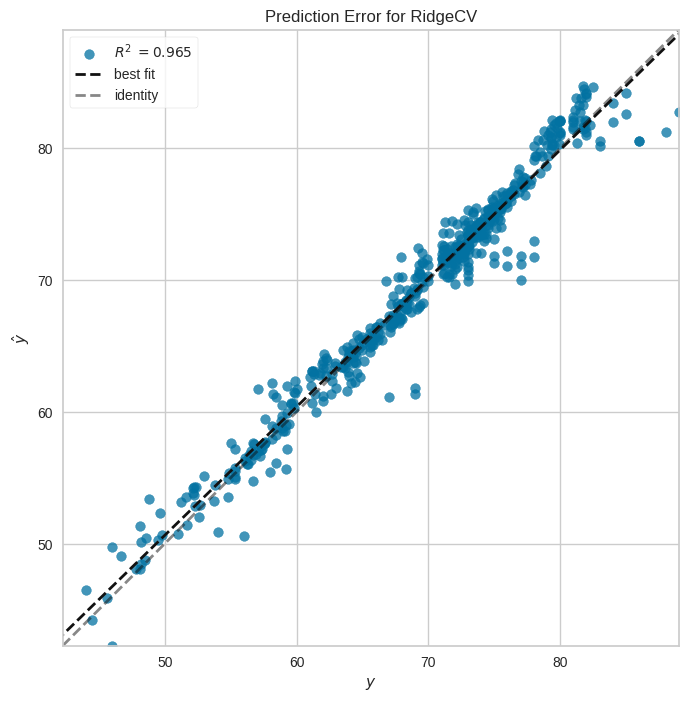

In [113]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(ridge_cv_one_hot,X_test,y_test,is_fitted=True)

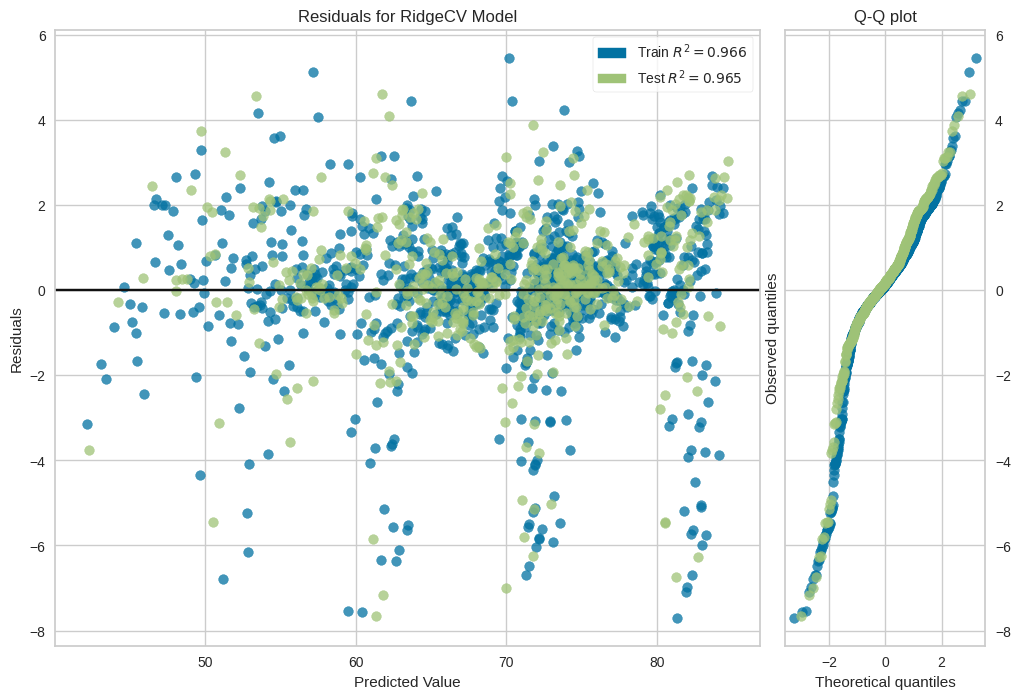

In [115]:
plt.figure(figsize=(12,8))
viz = residuals_plot(ridge_cv_one_hot,X_train,y_train,X_test,y_test,is_fitted=True,qqplot=True,hist=False)

In [117]:
# Lasso Regression
y_test_predicted = lasso_cv_one_hot.predict(X_test)
r2_lasso = lasso_cv_one_hot.score(X_test,y_test)

print('Mean squared error with test data:{}'.format(mean_squared_error(y_test,y_test_predicted)))
print('Normalized Mean squared error with test data:{}'.format(1 - r2_lasso))
print('R2 score with test data: {}'.format(r2_lasso))

Mean squared error with test data:2.5857618131518807
Normalized Mean squared error with test data:0.034874049067898816
R2 score with test data: 0.9651259509321012


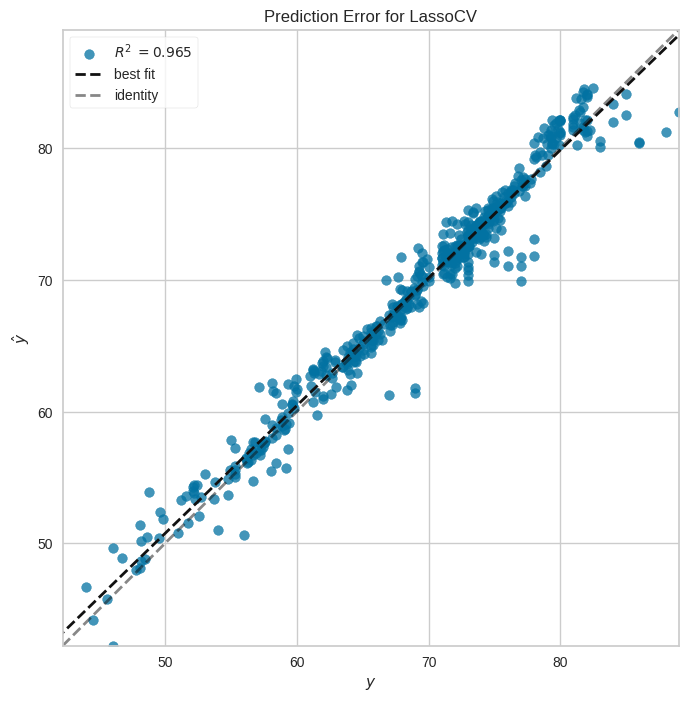

In [118]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lasso_cv_one_hot,X_test,y_test,is_fitted=True)

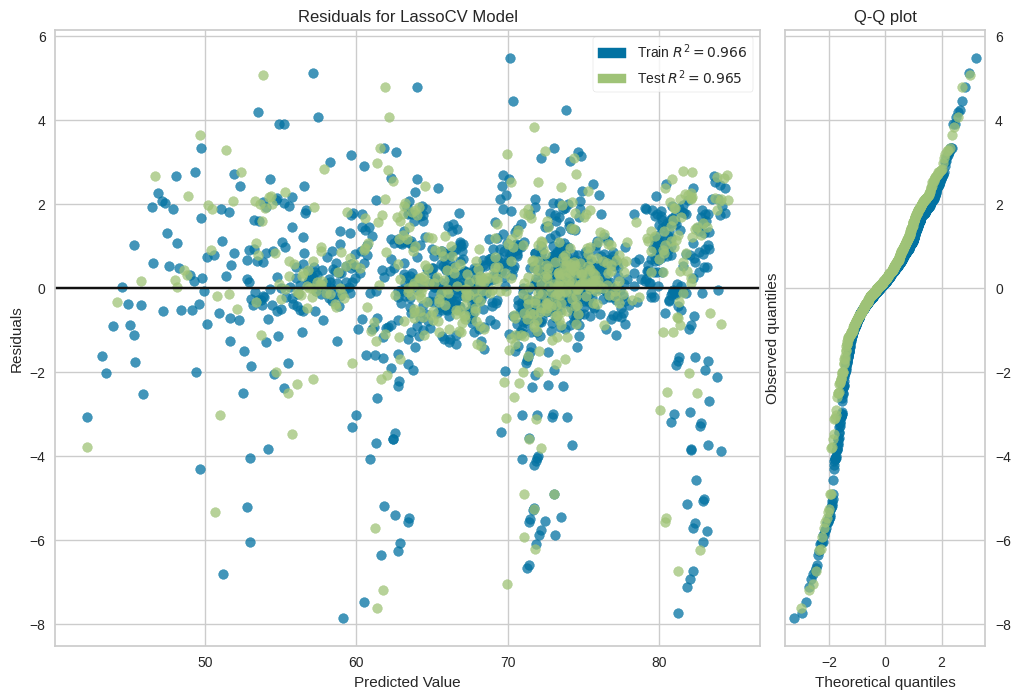

In [119]:
plt.figure(figsize=(12,8))
viz = residuals_plot(lasso_cv_one_hot,X_train,y_train,X_test,y_test,is_fitted=True,qqplot=True,hist=False)